In [1]:

import numpy as np
import matplotlib.pyplot as plt
import gzip
# Used for Loading MNIST
from struct import unpack


# Data Modelling

In [2]:

# https://gist.github.com/mGalarnyk/aa79813d7ecb0049c7b926d53f588ae1
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = gzip.open(imagefile, 'rb')
    labels = gzip.open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)


In [3]:
def replaceZeroes(data):
    min_nonzero = min(data[np.nonzero(data)]) 
    data[data == 0] = min_nonzero
    return data


In [4]:
train_img, train_lbl = loadmnist(
    'data/train-images-idx3-ubyte.gz', 'data/train-labels-idx1-ubyte.gz')
test_img, test_lbl = loadmnist(
    'data/t10k-images-idx3-ubyte.gz', 'data/t10k-labels-idx1-ubyte.gz')

In [5]:
print(train_img.shape)

(60000, 784)


In [6]:
print(train_lbl.shape)

(60000,)


In [7]:
print(test_img.shape)

(10000, 784)


In [8]:
print(test_lbl.shape)

(10000,)


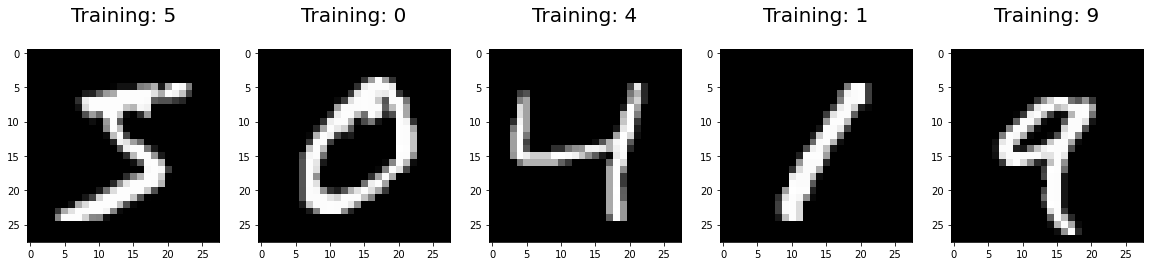

In [9]:
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(train_img[0:5], train_lbl[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize=20)


In [10]:
# This is how the computer sees the number 5
print(train_img[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

# Neural Networks

In [27]:
def neural_network(n_layers, epochs, eta):
    sizes = [len(train_img[0]), 10]
    for n_layer in n_layers[::-1]:
        sizes.insert(1, n_layer)
    print(sizes)

    train_img_norm = train_img/255
    test_img_norm = test_img/255

    layers = []

    for i in range(len(sizes)-1):
        layer = np.random.uniform(-1.,1.,size=(sizes[i], sizes[i+1]))/np.sqrt(sizes[i]*sizes[i+1])
        print("Layer", i+1, ":", layer.shape)
        layers.append(layer)

    def sigmoid(z):
        return 1/(1 + np.exp(-z))

    def d_sigmoid(z):
        return (np.exp(-z))/((1 + np.exp(-z))**2)
    
    def tanh(z):
        return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    
    def d_tanh(z):
        return 1 - tanh(z)**2

    def softmax(z):
        exp = np.exp(z - z.max())
        return exp/np.sum(exp, axis=0)

    def d_softmax(z):
        exp = np.exp(z - z.max())
        return exp/np.sum(exp,axis=0)*(1-exp/np.sum(exp,axis=0))

    def forward_backward_pass(X_input, target):
        targets = np.array([[1 if i == target[j] else 0 for i in range(len(layers[-1][0]))] for j in range(target.shape[0])])

        x_s = [X_input]
        x_l = []
        for i in range(len(layers)):
            x_l.append(x_s[i].dot(layers[i]))
            if i != len(layers)-1:
                x_s.append(tanh(x_l[i]))
            else:
                x_s.append(softmax(x_l[i].T).T)

        error = 2 * (x_s[-1] - targets) / x_s[-1].shape[0] * (d_softmax(x_l[-1].T).T)
        update_l = [(x_s[-2].T@error)]   
        for i in range(len(layers)-1, 0, -1):
            error = ((layers[i]).dot(error.T)).T*d_tanh(x_l[i-1])
            update_l.insert(0, x_s[i-1].T@error)

        return (x_s[i-1], update_l)



    count = 0
    accuracies = []
    for i_ in range(epochs-1):
        count += 1
        if count%500 == 0:
            cur_out = test_img
            for i in range(len(layers)-1):
                cur_out = sigmoid(cur_out.dot(layers[i]))
            out = np.argmax(softmax(cur_out.dot(layers[-1])), axis=1)
            acc = (out == test_lbl).mean()
            accuracies.append(acc)
            print("Epochs:", count)
            print("Current accuracy with test set:", acc)


        sample_index = np.random.choice(len(train_img_norm), 128)

        out, update_l = forward_backward_pass(train_img[sample_index].reshape(-1, 28*28), train_lbl[sample_index])
        for i in range(len(layers)):
            layers[i] -=  eta*update_l[i]

    cur_out = test_img
    for i in range(len(layers)-1):
        cur_out = sigmoid(cur_out.dot(layers[i]))
    out = np.argmax(softmax(cur_out.dot(layers[-1])), axis=1)
    acc = (out == test_lbl).mean()
    accuracies.append(acc)
    return (accuracies, out)

In [28]:
#n_layers = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
#n_layers = [100, 150, 200, 250, 300, 350, 400]
n_layers = [[350]]
for n_l in n_layers:
    accuracies, prediction = neural_network(n_l, epochs=10000, eta=0.005)

[784, 350, 10]
Layer 1 : (784, 350)
Layer 2 : (350, 10)
Epochs: 500
Current accuracy with test set: 0.9332
Epochs: 1000
Current accuracy with test set: 0.943
Epochs: 1500
Current accuracy with test set: 0.9489
Epochs: 2000
Current accuracy with test set: 0.9514
Epochs: 2500
Current accuracy with test set: 0.953
Epochs: 3000
Current accuracy with test set: 0.9559
Epochs: 3500
Current accuracy with test set: 0.9557
Epochs: 4000
Current accuracy with test set: 0.9578
Epochs: 4500
Current accuracy with test set: 0.9599
Epochs: 5000
Current accuracy with test set: 0.9628
Epochs: 5500
Current accuracy with test set: 0.9622
Epochs: 6000
Current accuracy with test set: 0.9631
Epochs: 6500
Current accuracy with test set: 0.9649
Epochs: 7000
Current accuracy with test set: 0.9646
Epochs: 7500
Current accuracy with test set: 0.9642
Epochs: 8000
Current accuracy with test set: 0.9661
Epochs: 8500
Current accuracy with test set: 0.9658
Epochs: 9000
Current accuracy with test set: 0.9668
Epochs: 950

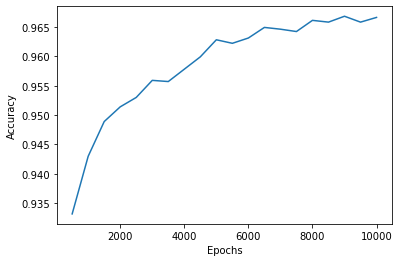

In [29]:
plt.figure()
plt.plot([500*i for i in range(1, int(10000/500)+1)], accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Confusion Matrix

In [ ]:
import seaborn as sns

In [ ]:
def nn_confusion_matrix(prediction, actual):
    cm = np.zeros(shape=(10,10))
    for i in range(len(prediction)):
        cm[actual[i]][prediction[i]] += 1/np.count_nonzero(actual == actual[i])
    return cm

In [ ]:
cm = nn_confusion_matrix(prediction, test_lbl)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".3f",
            linewidths=.5, square=True, cmap='RdYlGn')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {:.3f}'.format(max_accuracies[-1])
plt.title(all_sample_title, size=15)
plt.show()